# Table of Contents
* [Load data](#Load-data)
* [normalize text](#normalize-text)
* [new metalesson assignments](#new-metalesson-assignments)
* [test train splits](#test-train-splits)
	* [hide](#hide)
* [dataset stats](#dataset-stats)
	* [topic](#topic)


In [1]:
%%capture
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

import random
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import jsonschema

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
from tqa_utils import Evaluator
from analysis_utils import *

# Load data

In [4]:
dataset_root_dir = '/Users/schwenk/wrk/stb/dataset_releases/data_release_beta6/'
data_file = 'tqa_dataset_beta7_5.json'
data_file_path = dataset_root_dir + data_file

with open(os.path.join(dataset_root_dir, data_file_path), 'r') as f:
    ck12_combined_dataset_raw = json.load(f)

In [5]:
ck12_combined_dataset = deepcopy(ck12_combined_dataset_raw)

In [6]:
lesson_text, lesson_name_lookup = collect_filtered_lesson_text(ck12_combined_dataset, True, True)

In [7]:
quest_evaluator = Evaluator(data_file_path)
all_ndqs = quest_evaluator.build_question_lookup(by_type=True)['nonDiagramQuestions']
mc_questions = quest_evaluator.build_questions_by_subtype(all_ndqs)['Multiple Choice']
all_diagram_qs = quest_evaluator.build_question_lookup(by_type=True)['diagramQuestions']

In [8]:
old_ml_lookup = {lesson['globalID']: lesson['metaLessonID'] for lesson in ck12_combined_dataset_raw}

In [9]:
lesson_ids = [lid for lid, lesson in sorted(lesson_text.items(), key=lambda x: x[0])]
lesson_names = [lesson_name_lookup[lid] for lid in lesson_ids]
lesson_corp = [lesson for lid, lesson in sorted(lesson_text.items(), key=lambda x: x[0])]

# normalize text

In [349]:
lesson_corp[44]

'In the mid 1900s, people were startled to see the Cuyahoga River in Cleveland, Ohio, burst into flames! The river was so polluted with oil and other industrial wastes that it was flammable. Nothing could live in it. You can see the Cuyahoga River in Figure 21.16 \nDisasters such as rivers burning led to new U.S. laws to protect the water. For example, the Environmental Protection Agency (EPA) was established, and the Clean Water Act was passed. Now, water is routinely tested. Pollution is tracked to its source, and polluters are forced to fix the problem and clean up the pollution. They are also fined. These consequences have led industries, agriculture, and communities to pollute the water much less than before. \nMost water pollution comes from industry, agriculture, and municipal sources. Homes are part of the municipal source and the individuals and families that live in them can pollute the water supply. What can you do to reduce water pollution? Read the tips below. Properly dis

In [203]:
# tokens = wordpunct_tokenize(text)
# normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]

In [11]:
cached_sw = stopwords.words('english') + list(string.punctuation)
lemmatizer = WordNetLemmatizer()

In [78]:
def tokenize_and_stem(text, stopwords=cached_sw):
    tokens = wordpunct_tokenize(text)
    normalized_tokens = []
    for toke in tokens:
        cleaned_token = toke.strip().lower()
        if len(cleaned_token) > 3 and cleaned_token not in stopwords and cleaned_token.isalpha():
            stem = lemmatizer.lemmatize(cleaned_token)
            normalized_tokens.append(stem)
    return normalized_tokens

def tokenize_and_mark_sci_terms(text, stopwords=cached_sw, science_terms=None):
    tokens = wordpunct_tokenize(text)
    normalized_tokens = []
    for toke in tokens:
        cleaned_token = toke.strip().lower()
        if len(cleaned_token) > 3 and cleaned_token not in stopwords and cleaned_token.isalpha():
            stem = lemmatizer.lemmatize(cleaned_token)
            if stem in science_terms:
                normalized_tokens.append('__CONCEPT__')
            else:
                normalized_tokens.append(stem)
    return normalized_tokens

def tokenize_lesson(text):
    tokens = wordpunct_tokenize(text)
    normalized_tokens = []
    for toke in tokens:
        cleaned_token = toke.strip().lower()
        if cleaned_token and cleaned_token not in cached_sw and cleaned_token.isalpha():
             normalized_tokens.append(cleaned_token)
    return normalized_tokens

# new test train assignments

In [13]:
manual_assignments = {
                      "insects and other arthropods": "train",
                      "covalent bonds": "train",
                      "the sun and the earthmoon system": "train",
                      "the senses": "train",
                      "the respiratory system": "test",
                      "evolution and classification of plants": "test",
                      "the nervous system": "train",
                      "parts leaf": "train",
                      "volcanic eruptions": "train",
                      "introduction to the solar system": "train",
                      "nuclear energy": "train",
    
                      "seasons": "test",
                      "introduction to plants": "test",
                      "cell structures": "train",
                      "inside the atom": "test",
                      "inside earth": "test",
                      "vision and the eye": "test",
                      "the digestive system": "train",
                      "eclipses": "test",
                      "flow of energy": "test"
                     }

In [14]:
lesson_name_lookup_inverted = {v: k for k, v in lesson_name_lookup.items()}

In [16]:
# with open('output_data_from_nbs/flexbook_glossary.pkl', 'rb') as f:
#     glossary_terms = pickle.load(f)
    
with open('output_data_from_nbs/ck_12_vocab_words.pkl', 'rb') as f:
    glossary_terms = pickle.load(f)

In [17]:
stemmed_terms = [tokenize_and_stem(term)[0] for term in glossary_terms if tokenize_and_stem(term)]

In [18]:
all_words = [tokenize_and_stem(lesson) for lesson in lesson_corp]

In [19]:
all_words_set = set([word for lesson in all_words for word in lesson])

In [992]:
orig_text = ' '.join(tokenize_and_stem(test_text))

In [997]:
set(orig_text.split()).difference(set(sciw_removed.split()))

{'common',
 'destructive',
 'explosive',
 'figure',
 'fluid',
 'force',
 'image',
 'lake',
 'large',
 'magma',
 'ocean',
 'outer',
 'pressure',
 'resource',
 'smooth',
 'source',
 'stream',
 'surface',
 'thermal',
 'thunder'}

In [164]:
tfizer = TfidfVectorizer(analyzer='word', tokenizer=lambda x: tokenize_and_stem(x, cached_sw), ngram_range=(1,3), min_df = 0.05, max_df=0.8)
tfidf =  tfizer.fit_transform(lesson_corp)
feature_names = tfizer.get_feature_names() 

In [165]:
pairwise_similarity = tfidf * tfidf.T

In [166]:
with open('pairwise_similarity.pkl', 'wb') as f:
    pickle.dump(pairwise_similarity, f)

In [ ]:
flattened_dict = {k: v for d in list_of_dicts for k, v in d.items()}
flattened_dict = {**d1, **d2}
array.flatten()

In [122]:
build_marked_corp = [tokenize_and_mark_sci_terms(lesson, [], stemmed_terms) for lesson in lesson_corp]

In [128]:
corpus_marked_tokes = [item for sublist in build_marked_corp for item in sublist]

In [127]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_measures = nltk.collocations.QuadgramCollocationFinder()

In [ ]:
nltk.collocations.spearman_correlation

In [148]:
quad_finder = nltk.collocations.QuadgramCollocationFinder.from_words(corpus_marked_tokes)

In [154]:
quad_finder.apply_freq_filter(300)
quad_finder.nbest(bigram_measures.pmi, 20)

[('answer', 'question', 'that', 'follow'),
 ('click', '__CONCEPT__', 'left', 'below'),
 ('__CONCEPT__', 'left', 'below', 'what'),
 ('__CONCEPT__', 'click', '__CONCEPT__', 'left'),
 ('__CONCEPT__', 'called', '__CONCEPT__', '__CONCEPT__'),
 ('called', '__CONCEPT__', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'called', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', '__CONCEPT__', 'that'),
 ('__CONCEPT__', 'what', '__CONCEPT__', '__CONCEPT__'),
 ('from', '__CONCEPT__', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'what', '__CONCEPT__'),
 ('__CONCEPT__', 'from', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'this', '__CONCEPT__')]

In [157]:
phrase_bi_finder = BigramCollocationFinder.from_words(corpus_marked_tokes)

In [163]:
phrase_bi_finder.apply_freq_filter(700) 
phrase_bi_finder.nbest(bigram_measures.pmi, 20)

[('left', 'below'),
 ('click', '__CONCEPT__'),
 ('__CONCEPT__', 'left'),
 ('called', '__CONCEPT__'),
 ('__CONCEPT__', 'such'),
 ('different', '__CONCEPT__'),
 ('these', '__CONCEPT__'),
 ('__CONCEPT__', 'which'),
 ('other', '__CONCEPT__'),
 ('__CONCEPT__', 'also'),
 ('__CONCEPT__', 'called'),
 ('through', '__CONCEPT__'),
 ('__CONCEPT__', 'form'),
 ('their', '__CONCEPT__'),
 ('into', '__CONCEPT__'),
 ('__CONCEPT__', 'that'),
 ('most', '__CONCEPT__'),
 ('some', '__CONCEPT__'),
 ('when', '__CONCEPT__'),
 ('__CONCEPT__', 'what')]

In [155]:
phrase_tri_finder = TrigramCollocationFinder.from_words(corpus_marked_tokes)

In [156]:
phrase_tri_finder.apply_freq_filter(200) 
phrase_tri_finder.nbest(trigram_measures.pmi, 30)  

[('below', 'answer', 'question'),
 ('question', 'that', 'follow'),
 ('answer', 'question', 'that'),
 ('left', 'below', 'what'),
 ('click', '__CONCEPT__', 'left'),
 ('medium', 'click', '__CONCEPT__'),
 ('__CONCEPT__', 'left', 'below'),
 ('__CONCEPT__', 'below', 'answer'),
 ('below', 'click', '__CONCEPT__'),
 ('left', 'below', '__CONCEPT__'),
 ('below', 'what', '__CONCEPT__'),
 ('called', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'occurs'),
 ('high', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', 'called', '__CONCEPT__'),
 ('__CONCEPT__', 'describe', '__CONCEPT__'),
 ('describe', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'explain'),
 ('between', '__CONCEPT__', '__CONCEPT__'),
 ('include', '__CONCEPT__', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'include'),
 ('__CONCEPT__', '__CONCEPT__', 'describe'),
 ('__CONCEPT__', 'click', '__CONCEPT__'),
 ('__CONCEPT__', 'include', '__CONCEPT__'),
 ('__CONCEPT__', '__CONCEPT__', 'which'),
 ('three', '_

In [129]:
most_common_bigrams = []

for k,v in sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]:
    most_common_bigrams.append((' '.join(k), v))

In [106]:
tfizer = TfidfVectorizer(analyzer='word', tokenizer=lambda x: tokenize_and_mark_sci_terms(x, [], stemmed_terms), ngram_range=(1,3), min_df = 0.05)
tfidf =  tfizer.fit_transform(lesson_corp)
feature_names = tfizer.get_feature_names() 

In [107]:
pairwise_similarity_sw_removed = tfidf * tfidf.T

In [108]:
with open('pairwise_similarity_sw_removed.pkl', 'wb') as f:
    pickle.dump(pairwise_similarity_sw_removed, f)

In [167]:
num_clusters = 15
km = KMeans(n_clusters=num_clusters, max_iter=10000 , n_init=10, n_jobs=7)
km.fit(tfidf)
clusters = km.labels_.tolist()

feature_names = tfizer.get_feature_names()

In [92]:
cluster_members = defaultdict(list)
for idx, cluster in enumerate(clusters):
    cluster_members[cluster].append(lesson_ids[idx])

In [93]:
for cn, members, in cluster_members.items():
    for m in members:
        member_name = lesson_name_lookup[m]
        if 'ionic' in member_name:
            print(cn,m,  member_name)

11 L_0779 ionic bonds
11 L_0928 ionic bonding
11 L_0929 ionic compounds


In [94]:
cluster_membership_numbers = pd.Series(clusters).value_counts()
cluster_membership_numbers

9     184
1     124
7      95
12     87
11     81
2      67
3      61
14     54
6      54
5      54
0      54
10     46
4      42
13     41
8      32
dtype: int64

In [169]:
tt_assignments_id = defaultdict(list)
for c, members in cluster_members.items():
    member_names = [lesson_name_lookup[m] for m in members]
    assigned_split = 'train'
    rand_n = random.random()
    man_assigned = set(member_names).intersection(set(manual_assignments.keys()))
    if man_assigned:
        assigned_split = manual_assignments[man_assigned.pop()]
    elif rand_n > 0.95:
        assigned_split = 'test'
    tt_assignments_id[assigned_split] += members

tot_len = len(tt_assignments_id['test']) + len(tt_assignments_id['train'])
print(len(tt_assignments_id['test']), len(tt_assignments_id['train']))
print(len(tt_assignments_id['test']) / tot_len, len(tt_assignments_id['train'])/ tot_len)

320 756
0.29739776951672864 0.7026022304832714


In [170]:
with open('new_tt_assignments.json', 'w') as f:
    json.dump(tt_assignments_id, f)

In [68]:
top_centroids = km.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    print("Cluster {} words:".format(i))   
    for ind in top_centroids[i, :6]: #replace 6 with n words per cluster
        print(' {}'.format(feature_names[ind]))
    print()
    print()

Cluster 0 words:
 wire
 coil
 flowing
 cloud
 device
 form


Cluster 1 words:
 specie
 organism
 insect
 live
 relationship
 animal


Cluster 2 words:
 wave
 travel
 sound
 medium
 wavelength
 particle


Cluster 3 words:
 layer
 soil
 fossil
 clay
 rock
 region


Cluster 4 words:
 north
 wind
 volcano
 continent
 earth
 south


Cluster 5 words:
 cell
 pathogen
 chromosome
 disease
 cause
 male


Cluster 6 words:
 object
 greater
 moving
 machine
 newton
 input


Cluster 7 words:
 rock
 mineral
 fossil
 sedimentary
 igneous
 sediment


Cluster 8 words:
 reactant
 reaction
 product
 bond
 oxygen
 equation


Cluster 9 words:
 scientist
 research
 example
 evidence
 data
 people


Cluster 10 words:
 proton
 neutron
 atom
 alpha
 particle
 isotope


Cluster 11 words:
 particle
 change
 fixed
 substance
 gas
 tire


Cluster 12 words:
 atom
 electron
 bond
 compound
 ion
 form


Cluster 13 words:
 organism
 plant
 dioxide
 cell
 protist
 living


Cluster 14 words:
 element
 electron
 metal
 r

# test train splits (old method)

In [11]:
from pdfextraction.validate_and_split import TestTrainSplitter
test_train_splitter = TestTrainSplitter(dataset_root_dir, data_file)

*insects and other arthropods to train*

In [12]:
tt_split, debug = test_train_splitter.perform_split(manual_assignments=manual_assignments, debug=True)

NameError: name 'manual_assignments' is not defined

In [331]:
trial_counter = 1

In [14]:
exp_dir = 'test_train_split_trials/'

In [446]:
manual_assignments = {
                      "ML_0260": {"lesson_name": "insects and other arthropods":"train"},
                      "ML_0310": {"lesson_name": "covalent bonds":"train"},
                      "ML_0243": {"lesson_name": "sun earth moon system":"train"},
                      "ML_0288": {"lesson_name": "the senses":"train"},
                      "ML_0006": {"lesson_name": "respiratory system":"test"},
                      "ML_0344": {"lesson_name": "evolution and classifiaction plants":"test"},
                      "ML_0023": {"lesson_name": "the nervous system":"train"},
                      "ML_0164": {"lesson_name": "parts leaf":"train"},
                      "ML_0383": {"lesson_name": "volcanoes":"train"},
                      "ML_0508": {"lesson_name": "solar system":"train"},
                      "ML_0010": {"lesson_name": "nuclear energy":"train"},  
    
                      "ML_0368": {"lesson_name": "seasons":"test"},
                      "ML_0164": {"lesson_name": "introduction to plants":"test"},
                      "ML_0440": {"lesson_name": "cell structures":"train"},
                      "ML_0423": {"lesson_name": "inside the atom":"test"},
                      "ML_0070": {"lesson_name": "inside the earth":"test"},
                      "ML_0490": {"lesson_name": "vision and the eye":"test"},
                      "ML_0403": {"lesson_name": "the digestive system":"train"},
                      "ML_0433": {"lesson_name": "eclipses":"test"},
                      "ML_0434": {"lesson_name": "flow of energy":"test"}, 
                     }

man_assigned_lesson_names = [v['lesson_name'] for v in manual_assignments.values()]

In [363]:
from pdfextraction.validate_and_split import TestTrainSplitter

def write_trial_split(tt_split, exp_dir, multirun_idx):
    global trial_counter
    record_filename = os.path.join(exp_dir,'record_splits_' + str(trial_counter) + '_' +str(multirun_idx) +  '.json')     
    with open(record_filename, 'w') as f:
        json.dump(tt_split, f)
    print('saving trial ' + str(trial_counter) + '_' + str(multirun_idx))

def split_and_save(manual_assignments, multirun_idx=0):
    global trial_counter
    test_train_splitter = TestTrainSplitter(dataset_root_dir, data_file)
    tt_split, debug = test_train_splitter.perform_split(manual_assignments=manual_assignments)
    write_trial_split(tt_split, exp_dir, multirun_idx)
    return  tt_split

In [364]:
n_trials = 10
split_trials = [split_and_save(manual_assignments, i) for i in range(n_trials)]  
trial_counter += 1

saving trial 6_0
saving trial 6_1
saving trial 6_2
saving trial 6_3
saving trial 6_4
saving trial 6_5
saving trial 6_6
saving trial 6_7
saving trial 6_8
saving trial 6_9


6_0 is the winner

In [365]:
computed_stats_non_diagram = [test_train_splitter.compute_split_stats(this_split) for this_split in split_trials]
computed_stats_diagram = [test_train_splitter.compute_split_stats(this_split, True) for this_split in split_trials]

In [366]:
split_trials_test_fracts = [{k:v['test_fraction'] for k, v in trial.items()} for trial in computed_stats_diagram]
split_trials_test_counts = [{k:v['test'] for k, v in trial.items()} for trial in computed_stats_diagram]
split_trial_df = pd.DataFrame(split_trials_test_fracts)
split_trial_df = split_trial_df.apply(pd.to_numeric)
split_stats_df = pd.concat([split_trial_df, pd.DataFrame(split_trials_test_counts)], axis=1)
split_stats_df_diagram = split_stats_df.apply(pd.to_numeric)

split_trials_test_fracts = [{k:v['test_fraction'] for k, v in trial.items()} for trial in computed_stats_non_diagram]
split_trials_test_counts = [{k:v['test'] for k, v in trial.items()} for trial in computed_stats_non_diagram]
split_trial_df = pd.DataFrame(split_trials_test_fracts)
split_trial_df = split_trial_df.apply(pd.to_numeric)
split_stats_df = pd.concat([split_trial_df, pd.DataFrame(split_trials_test_counts)], axis=1)
split_stats_df_non_diagram = split_stats_df.apply(pd.to_numeric)

In [367]:
split_stats_df_non_diagram

,n_diagram_questions,n_instructional_diagrams,n_lessons,n_text_questions,n_topics,n_diagram_questions,n_instructional_diagrams,n_lessons,n_text_questions,n_topics
0,0.378,0.290,0.215,0.229,0.222,4748,80,231,3095,1113
1,0.459,0.413,0.217,0.233,0.235,5767,114,233,3159,1178
2,0.383,0.308,0.219,0.211,0.214,4818,85,236,2851,1072
3,0.402,0.344,0.209,0.214,0.212,5057,95,225,2894,1065
4,0.409,0.348,0.214,0.216,0.218,5137,96,230,2918,1094
5,0.396,0.286,0.195,0.197,0.197,4982,79,210,2664,987
6,0.391,0.315,0.196,0.219,0.221,4909,87,211,2958,1106
7,0.403,0.330,0.210,0.215,0.222,5059,91,226,2917,1115
8,0.389,0.312,0.204,0.204,0.208,4884,86,220,2758,1043
9,0.411,0.351,0.215,0.218,0.211,5161,97,231,2955,1058


In [368]:
split_stats_df_diagram

,n_diagram_questions,n_instructional_diagrams,n_lessons,n_text_questions,n_topics,n_diagram_questions,n_instructional_diagrams,n_lessons,n_text_questions,n_topics
0,0.378,0.290,0.224,0.221,0.216,4748,80,19,493,169
1,0.459,0.413,0.376,0.380,0.404,5767,114,32,849,317
2,0.383,0.308,0.247,0.222,0.251,4818,85,21,495,197
3,0.402,0.344,0.294,0.279,0.279,5057,95,25,622,219
4,0.409,0.348,0.294,0.283,0.295,5137,96,25,631,231
5,0.396,0.286,0.247,0.237,0.233,4982,79,21,530,183
6,0.391,0.315,0.259,0.256,0.247,4909,87,22,572,194
7,0.403,0.330,0.271,0.251,0.296,5059,91,23,560,232
8,0.389,0.312,0.247,0.236,0.263,4884,86,21,527,206
9,0.411,0.351,0.282,0.260,0.277,5161,97,24,580,217


## hide

In [ ]:
split_stats_df.columns = ['fract_diagram_questions', 'fract_instructional_diagrams', 'fract_text_questions', 'fract_topics', 'n_diagram_questions', 'n_instructional_diagrams', 'n_text_questions', 'n_topics']

In [319]:
len(tt_split['test'] + tt_split['train'])

1076

In [126]:
# sorted(debug_tt_splits['train'], key= lambda x: x[1])

# sorted(debug_tt_splits['test'], key= lambda x: x[1])

In [315]:
print('L_0575' in tt_split['test'])
print('L_0575' in tt_split['train'])

test_st = 'te'
test_st.format()


manual_assignments.keys()

test_train_splitter.compute_split_stats(tt_split)

False
True


In [261]:
test_st = 'te'
test_st.format()

manual_assignments = {"ML_0289": {"lesson_name": "flow of energy":"test"}, "ML_0505": {"lesson_name": "insect reproduction and life cycle":"train"}}

manual_assignments.keys()

'te'

In [8]:
def record_validation_errors(dataset, schema):
    qs_removed = []
    validator = jsonschema.Draft4Validator(schema)
    for error in sorted(validator.iter_errors(dataset), key=lambda x: x.absolute_path[0]):
        print(error)
        lesson, quest, question_class, q_number = list(error.absolute_schema_path)[:4]
        problem_q_section = dataset[subject][lesson][quest][question_class]
        if q_number in problem_q_section.keys():
            print(dataset[subject][lesson][quest][question_class].pop(q_number))
            qs_removed.append(dataset[subject][lesson][quest][question_class].pop(q_number))
    return qs_removed

In [167]:
# ml_ids_train, ml_ids_test, debug_train = test_train_splitter.perform_split()

# ml_ids_train, ml_ids_test, debug_train = test_train_splitter.perform_split()

In [9]:
validator = jsonschema.Draft4Validator(new_schema)
for error in sorted(validator.iter_errors(ck12_combined_dataset_raw), key=lambda x: x.absolute_path[0]):
    print(error.message)
    print(error.absolute_path)
    print()

NameError: name 'new_schema' is not defined

# dataset stats

## topic 

In [28]:
combined_topics = [lesson['lessonName'] for lesson in ck12_combined_dataset]
topic_series = pd.Series(combined_topics).value_counts()

In [30]:
topic_series[:20]

ecosystems                             3
water pollution                        3
elastic force                          2
cellular respiration                   2
earth as a magnet                      2
work                                   2
birds                                  2
friction                               2
igneous rocks                          2
chemical equations                     2
changes of state                       2
choosing healthy foods                 2
air pollution                          2
electric circuits                      2
fish                                   2
radioactive decay                      2
primates                               2
newtons second law                     2
radioactivity                          2
properties of electromagnetic waves    2
dtype: int64

In [31]:
len(combined_topics)

1076

In [33]:
q_types = []
for lesson in ck12_combined_dataset:
    for question in lesson['questions']['nonDiagramQuestions'].values():
        q_types.append(question['questionSubType'])
question_counts = pd.Series(q_types).value_counts()
print('total number of questions = ' + str(question_counts.sum()))
question_counts

total number of questions = 18929


Multiple Choice      6582
True or False        5400
Fill in the Blank    3643
Matching             1711
Short Answer         1593
dtype: int64

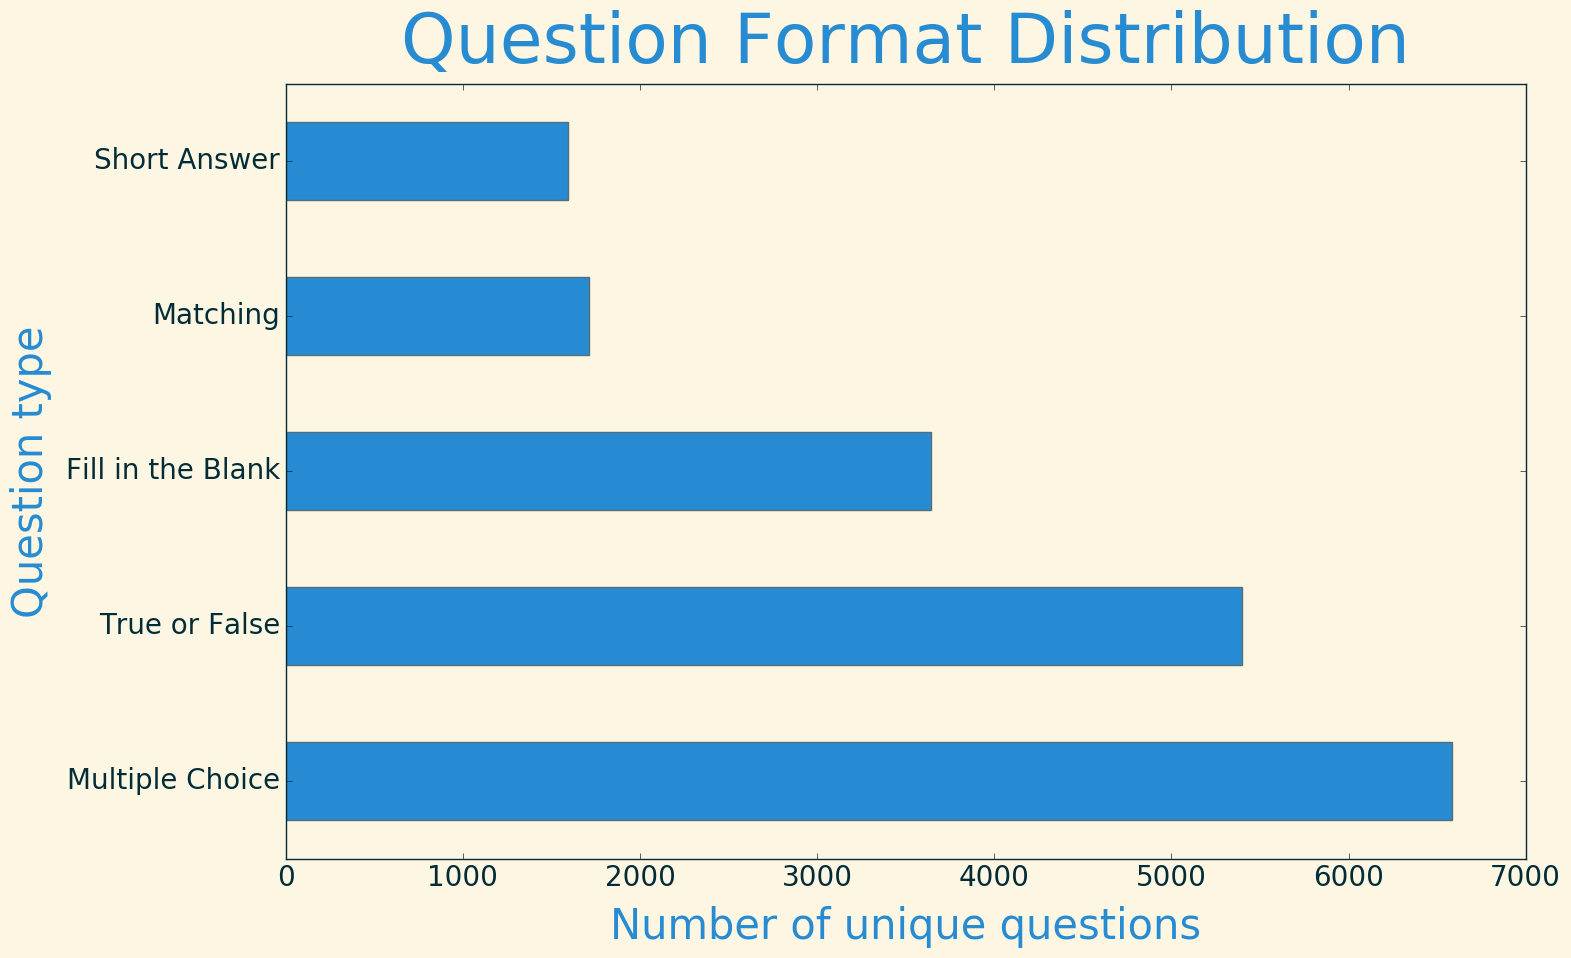

In [34]:
_ = question_counts.plot(kind="barh")
plt.title('Question Format Distribution', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Question type", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Number of unique questions", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [35]:
usable_questions = question_counts[:2].append(question_counts[3:4])

In [38]:
sum(usable_questions)

13693